In [25]:
import gluonts
gluonts.__version__

'0.4.2'

In [26]:
import mxnet
mxnet.__version__

'1.4.1'

In [27]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


In [4]:
dataname = "m4_yearly_finance"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_finance.


In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_domain', 'm4_yearly_finance', 'm4_yearly_industry', 'm4_yearly_macro', 'm4_yearly_micro', 'm4_yearly_other']


In [6]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [7]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='12M'),
 'target': array([ 6860.7,  7319.4,  7760.5,  8079.3,  8724.5,  8846. ,  8261.6,
         7345.2,  6741.3,  7106.4,  7367.3,  7846.6,  8057.5,  8069.3,
         7726.9,  8050. ,  9531.9, 14004. , 11898.4, 11309. , 12920.1,
        12503.1, 11920.8, 11452.4, 10237.5,  9543.2,  9289.7, 10987.1,
        12746.3, 11557.4], dtype=float32),
 'feat_static_cat': array([1], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_finance/train/m4_yearly_finance_train.json'), line=1), row=1)}

## Plot Series

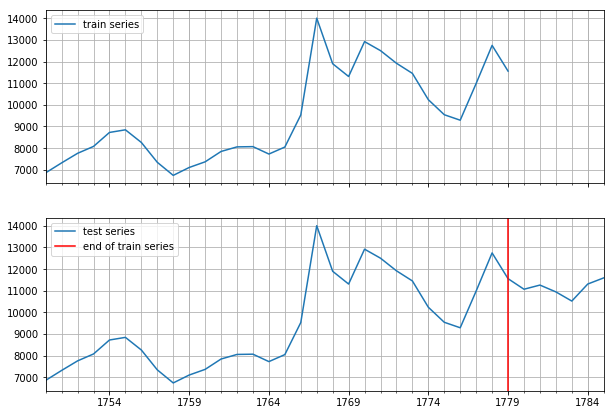

In [28]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [29]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator


In [30]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df


# Yearly

## `Yearly_industry`

...

## Other

In [35]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_daily", seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:downloading and processing m4_daily


Seed: 42
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/test/data.json


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.13it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[0] Elapsed time 5.233 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.243338
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.54it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[1] Elapsed time 5.395 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.488652
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.78it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 5.326 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.521486
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.66it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[3] Elapsed time 5.089 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.356864
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.47it/s, avg_e

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.528775
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.15it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[37] Elapsed time 5.224 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.526679
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.40it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[38] Elapsed time 5.157 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.518658
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.17it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[39] Elapsed time 5.220 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.579981
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.79it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[40] Elapsed time 5.055 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.523144
INFO:root:Epoch[41] Learning rate is 0.001
100%|████████

INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.18it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[74] Elapsed time 5.215 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.391995
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.71it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[75] Elapsed time 5.077 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.438334
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.33it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[76] Elapsed time 5.176 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.462339
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.08it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[77] Elapsed time 4.981 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.400132
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.61it/s, avg_epoch_loss=5.43]
INF

100%|██████████| 100/100 [00:05<00:00, 19.84it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[110] Elapsed time 5.042 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.422009
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[111] Elapsed time 5.145 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.367659
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.87it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[112] Elapsed time 5.035 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.365958
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.54it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[113] Elapsed time 5.120 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.440766
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.61it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[114] E

100%|██████████| 100/100 [00:05<00:00, 19.28it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[146] Elapsed time 5.190 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.425604
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.82it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[147] Elapsed time 5.047 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.379900
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[148] Elapsed time 5.135 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.334987
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.65it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[149] Elapsed time 5.091 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.393050
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.35it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[150] 

100%|██████████| 100/100 [00:05<00:00, 19.42it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[182] Elapsed time 5.151 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.379942
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.97it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[183] Elapsed time 5.274 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.430936
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.79it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[184] Elapsed time 5.055 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.352929
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.42it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[185] Elapsed time 5.154 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.343611
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[186] Elapsed time

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[219] Elapsed time 5.135 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.377480
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[220] Elapsed time 5.190 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.410939
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.76it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[221] Elapsed time 5.062 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.317259
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.28it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[222] Elapsed time 5.191 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.354866
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.58it/s, avg_epoch_

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.335631
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.54it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[256] Elapsed time 5.121 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.345302
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.20it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[257] Elapsed time 5.210 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.415479
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[258] Elapsed time 5.134 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.341672
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.24it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[259] Elapsed time 5.198 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.375190
INFO:root:Epoch[260] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 19.13it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[292] Elapsed time 5.229 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.358950
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.57it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[293] Elapsed time 5.112 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.357969
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.07it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[294] Elapsed time 5.247 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.416387
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.60it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[295] Elapsed time 5.105 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.349950
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.09it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[296] Elapsed time 

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.41it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[329] Elapsed time 5.155 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.324802
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[330] Elapsed time 5.115 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.342415
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.17it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[331] Elapsed time 5.219 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.414125
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.39it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[332] Elapsed time 5.161 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.387884
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.00it/s, avg_epoch_

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.386722
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.10it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[366] Elapsed time 5.237 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.318151
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[367] Elapsed time 5.082 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.362136
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.19it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[368] Elapsed time 5.213 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.435538
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.71it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[369] Elapsed time 5.076 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.379620
INFO:root:Epoch[370] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 19.05it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[402] Elapsed time 5.254 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=5.365909
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[403] Elapsed time 5.132 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.310400
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[404] Elapsed time 5.193 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.422618
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.94it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[405] Elapsed time 5.020 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=5.350400
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.33it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[406] Elapsed time 

INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.74it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[439] Elapsed time 5.068 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.355148
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[440] Elapsed time 5.115 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.333423
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.18it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[441] Elapsed time 5.216 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.393556
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.14it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[442] Elapsed time 5.227 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.362504
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.71it/s, avg_epoch_

INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=5.319130
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.38it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[476] Elapsed time 5.163 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.366653
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.66it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[477] Elapsed time 5.089 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.323347
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.83it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[478] Elapsed time 5.312 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=5.385163
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.57it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[479] Elapsed time 5.113 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=5.353329
INFO:root:Epoch[480] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.348174  0.031966  39.242135            0.028677            0.012888   

   seed  epochs  num_batches  
0    42     500          100  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 20.97it/s, avg_epoch_loss=8]
INFO:root:Epoch[0] Elapsed time 4.772 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.003216
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.30it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[1] Elapsed time 5.184 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.541196
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.95it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[2] Elapsed time 5.279 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.470537
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.54it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[3] Elapsed time 5.119 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.325708
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.99it/s, avg_epoch_loss=6.

100%|██████████| 100/100 [00:05<00:00, 19.00it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 5.269 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.577822
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.18it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[38] Elapsed time 5.217 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.518041
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.29it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[39] Elapsed time 5.187 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.570409
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.32it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[40] Elapsed time 5.180 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.600550
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.39it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[41] Elapsed time 5.159 seconds

100%|██████████| 100/100 [00:05<00:00, 19.44it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[74] Elapsed time 5.146 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.418822
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.31it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[75] Elapsed time 5.180 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.468581
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[76] Elapsed time 5.065 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.437504
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.37it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[77] Elapsed time 5.167 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.503578
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.53it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[78] Elapsed time 5.124 seconds

100%|██████████| 100/100 [00:05<00:00, 19.30it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[110] Elapsed time 5.185 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.459546
INFO:root:Loading parameters from best epoch (100)
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[111] Elapsed time 5.066 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.396563
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[112] Elapsed time 5.192 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.380347
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.52it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[113] Elapsed time 5.125 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.391438
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 18.

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.13it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[146] Elapsed time 5.231 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.420212
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.86it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[147] Elapsed time 5.304 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.411488
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.77it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[148] Elapsed time 5.061 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.378313
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.06it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[149] Elapsed time 5.250 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.362396
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.02it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.361786
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.05it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[183] Elapsed time 5.252 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.424844
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.81it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[184] Elapsed time 5.051 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.374624
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.35it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[185] Elapsed time 5.172 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.394051
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.98it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[186] Elapsed time 5.270 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.371637
INFO:root:Epoch[187] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 19.37it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[219] Elapsed time 5.166 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.367755
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.32it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[220] Elapsed time 5.179 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.448117
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.39it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[221] Elapsed time 5.161 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.388517
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.28it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[222] Elapsed time 5.188 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.338132
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.30it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[223] Elapsed time

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.31it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[256] Elapsed time 5.180 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.342788
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.91it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[257] Elapsed time 5.289 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.411581
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.06it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[258] Elapsed time 5.250 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.421689
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.50it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[259] Elapsed time 5.132 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.377719
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.42it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.364794
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.03it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[293] Elapsed time 5.258 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.380359
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.30it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[294] Elapsed time 5.184 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.353639
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[295] Elapsed time 5.191 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.448625
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[296] Elapsed time 5.085 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.366327
INFO:root:Epoch[297] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 19.29it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[329] Elapsed time 5.186 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.430550
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[330] Elapsed time 5.065 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.360463
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.77it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[331] Elapsed time 5.329 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.368396
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.86it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[332] Elapsed time 5.305 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.336493
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.46it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[333] Elapsed time

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.97it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[366] Elapsed time 5.274 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.379855
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[367] Elapsed time 5.064 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.364576
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.73it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[368] Elapsed time 5.983 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.377641
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.67it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[369] Elapsed time 5.085 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.358714
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.06it/s, avg_epoch_

INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=5.360907
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.52it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[403] Elapsed time 5.710 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.401945
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.40it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[404] Elapsed time 5.157 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.284354
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.04it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[405] Elapsed time 5.254 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=5.308021
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.37it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[406] Elapsed time 5.165 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=5.345837
INFO:root:Epoch[407] Learning rate is 5e-05


100%|██████████| 100/100 [00:05<00:00, 19.12it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[439] Elapsed time 5.232 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.346989
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.08it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[440] Elapsed time 5.242 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.424574
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.47it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[441] Elapsed time 5.138 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.354863
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[442] Elapsed time 5.191 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.327126
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.14it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[443] Elapsed time

INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.44it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[476] Elapsed time 5.147 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.327562
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.11it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[477] Elapsed time 5.234 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.409187
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[478] Elapsed time 5.144 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=5.350924
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.05it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[479] Elapsed time 5.250 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=5.320164
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.29it/s, avg_epoch_

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.71808  0.034493  42.716021            0.031645            0.013875    43   

   epochs  num_batches  
0     500          100  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 20.51it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[0] Elapsed time 4.879 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.249468
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.22it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[1] Elapsed time 5.205 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.444575
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.19it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[2] Elapsed time 5.214 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.437889
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.64it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[3] Elapsed time 5.094 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.336977
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.14it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.59it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[37] Elapsed time 5.106 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.586377
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.34it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[38] Elapsed time 5.173 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.562476
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.26it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[39] Elapsed time 5.195 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.551877
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.63it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[40] Elapsed time 5.098 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.509103
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[41] Elapsed time 5.192 seconds

100%|██████████| 100/100 [00:05<00:00, 18.72it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[74] Elapsed time 5.347 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.400887
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.41it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[75] Elapsed time 5.155 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.368141
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.25it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[76] Elapsed time 5.196 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.443003
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.14it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[77] Elapsed time 5.227 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.435531
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.55it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[78] Elapsed time 5.699 sec

100%|██████████| 100/100 [00:05<00:00, 19.17it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[110] Elapsed time 5.218 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.404870
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.44it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[111] Elapsed time 5.147 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.377756
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 17.06it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[112] Elapsed time 5.864 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.332950
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.66it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[113] Elapsed time 5.089 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.427262
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.46it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[114] E

100%|██████████| 100/100 [00:05<00:00, 18.89it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[146] Elapsed time 5.298 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.363759
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.68it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[147] Elapsed time 5.659 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.437391
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[148] Elapsed time 5.133 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.393459
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.24it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[149] Elapsed time 5.201 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.389410
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.22it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.38it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[183] Elapsed time 5.164 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.365164
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.33it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[184] Elapsed time 5.174 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.415500
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.03it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[185] Elapsed time 5.256 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.373357
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[186] Elapsed time 5.192 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.387965
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.50it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.341817
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.42it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[220] Elapsed time 5.152 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.384267
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.12it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[221] Elapsed time 5.234 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.402957
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[222] Elapsed time 5.144 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.407569
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.04it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[223] Elapsed time 5.255 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.367555
INFO:root:Epoch[224] Learning rate is 5e-05


100%|██████████| 100/100 [00:05<00:00, 19.40it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[256] Elapsed time 5.159 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.347581
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[257] Elapsed time 5.136 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.362573
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.32it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[258] Elapsed time 5.179 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.403868
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[259] Elapsed time 5.136 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.431206
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[260] Elapsed time 

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.30it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[293] Elapsed time 5.184 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.315722
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.73it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[294] Elapsed time 5.072 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.408890
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.92it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[295] Elapsed time 5.288 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.388817
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.70it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[296] Elapsed time 5.077 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.372448
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.04it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.349109
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.20it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[330] Elapsed time 5.209 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.316021
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.42it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[331] Elapsed time 5.150 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.378855
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.19it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[332] Elapsed time 5.213 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.370517
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.60it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[333] Elapsed time 5.104 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.366427
INFO:root:Epoch[334] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 19.23it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[366] Elapsed time 5.203 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.355508
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.62it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[367] Elapsed time 5.372 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.359460
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.71it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[368] Elapsed time 5.347 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.376702
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.85it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[369] Elapsed time 5.307 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.417016
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.08it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[370] Elapsed time

INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.31it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[403] Elapsed time 5.183 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.336317
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.07it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[404] Elapsed time 5.246 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.360704
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.43it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[405] Elapsed time 5.149 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=5.299093
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.25it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[406] Elapsed time 5.198 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=5.383760
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_l

INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.407059
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.35it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[440] Elapsed time 5.170 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.369577
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.15it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[441] Elapsed time 5.226 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.351727
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.96it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[442] Elapsed time 5.276 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.294153
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.07it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[443] Elapsed time 5.245 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=5.417260
INFO:root:Epoch[444] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 19.42it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[476] Elapsed time 5.153 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.383299
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.60it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[477] Elapsed time 5.104 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.408967
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.88it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[478] Elapsed time 5.297 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=5.347352
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.17it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[479] Elapsed time 5.219 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=5.320051
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[480] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.351016  0.031993  39.693826            0.028225             0.01297   

   seed  epochs  num_batches  
0    44     500          100  
Seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 20.40it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[0] Elapsed time 4.906 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.276431
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.99it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[1] Elapsed time 5.268 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.465541
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.74it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[2] Elapsed time 5.337 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.455441
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.07it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[3] Elapsed time 5.245 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.368487
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss

KeyboardInterrupt: 

In [ ]:
results = pd.DataFrame()

for i in range(100, 501, 50):
    print("Seed:", i)
    df = deepar(data="m4_weekly", seed=42, epochs=i, batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(50, 501, 50):
    print("Epochs:", i)
    df = deepar(data="m4_hourly", seed=42, epochs=i, batches=100)
    pprint(df)
    results = results.append(df)

results

# Monthly

In [16]:
%%time
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_monthly_micro", seed=i, epochs=172, batches=200)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:03<?, ?it/s, avg_epoch_loss=8.49]


KeyboardInterrupt: 

In [17]:
%%time
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_monthly_micro", seed=i, epochs=343, batches=100)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt



### Yearly Subsets

In [18]:
# %%time
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_finance", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_yearly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# %%time
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_macro", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
# %%time
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_industry", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
# %%time
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_micro", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results